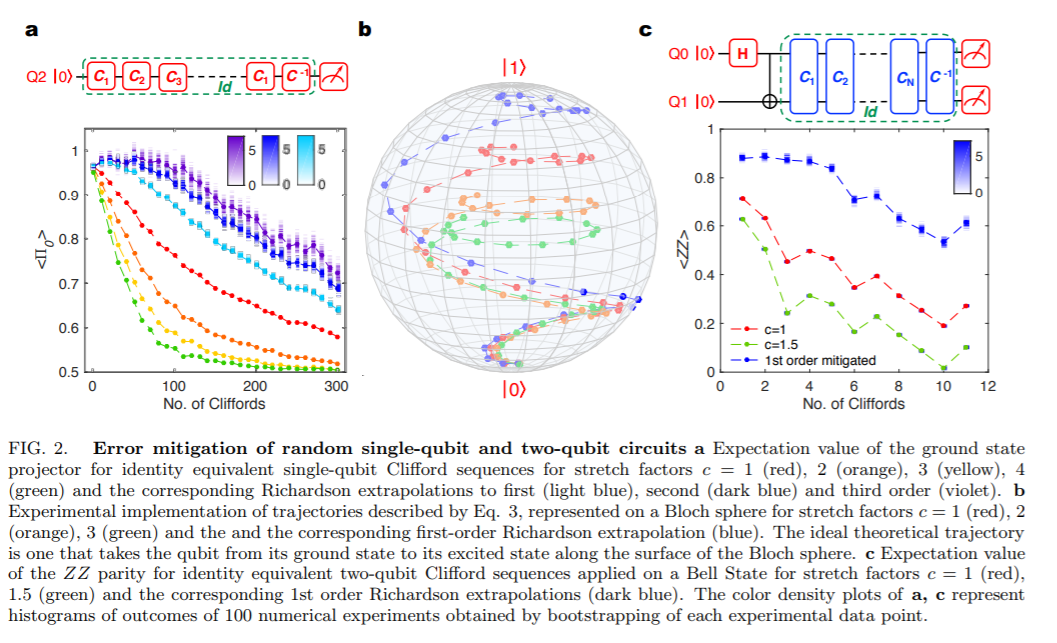

## Circuit:

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.tools import visualization as qplt

In [12]:
from qiskit import Aer
import qiskit.providers.aer as aer
from qiskit.providers.aer import QasmSimulator, StatevectorSimulator, UnitarySimulator

In [13]:
# Import the noise model object
from qiskit.providers.aer.noise import NoiseModel

# Import all standard errors
from qiskit.providers.aer.noise.errors import *  

# Import noise base clases
from qiskit.providers.aer.noise.errors.quantum_error import QuantumError
from qiskit.providers.aer.noise.errors.readout_error import ReadoutError

In [14]:
def XPairs(gateCount, qReg, qCirc, noiseModel, bitIdx):

    # Perform [count] pairs of hadarmards - should ideally equal to the identity
    for i in range(gateCount):
        qCirc.x(qReg[bitIdx])
        qCirc.x(qReg[bitIdx])

In [15]:
def CompileAndSimulate(gateCount, noiseModel, n_qubits, bitIdx, debug = False):
    
    # Simulator
    qSimulator = QasmSimulator()
    
    # System Specification
    qReg = QuantumRegister(n_qubits)
    qClas = ClassicalRegister(n_qubits)
    qCirc = QuantumCircuit(qReg, qClas)
    
    # Perform the X's
    XPairs(gateCount, qReg, qCirc, noiseModel, bitIdx)
    
    # Measure
    qCirc.measure(qReg, qClas)
    
    # Debug: Print the error model and plot the circuit
    if(debug):
        print(noiseModel)
        print(qCirc.draw())
    
    # Compile the noisy circuit
    qObj = qiskit.compile(qCirc, qSimulator, basis_gates = noiseModel.basis_gates)

    # Run the noisy simulation
    result = qSimulator.run(qObj, noise_model = noiseModel).result()
    counts = result.get_counts(0)

    if(debug):
        print(counts)
    
    return counts

## Try with one simulation

NoiseModel:
  Instructions with noise: ['x']
  Specific qubit errors: [('x', [0])]
           ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌─┐
q241_0: |0>┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤M├
           └───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└───┘└╥┘
 c241_0: 0 ═══════════════════════════════════════════════════╩═
                                                                
{'1': 160, '0': 864}
{'1': 160, '0': 864}


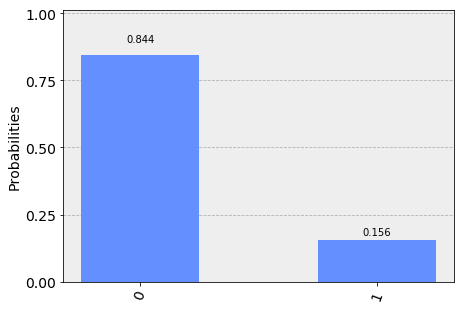

In [16]:
lamb = 0.02
n_qubits = 1
bitIdx = 0

# QuantumError objects
error = pauli_error([('X', lamb), ('I', 1 - lamb)])

# Add errors to noise model
noiseModel = NoiseModel()
noiseModel.add_quantum_error(error, ['x'], [bitIdx])

counts = CompileAndSimulate(gateCount = 5, noiseModel = noiseModel, n_qubits = n_qubits, bitIdx = bitIdx, debug = True)

print(counts)
qplt.plot_histogram(counts)

## Multiple Simulations

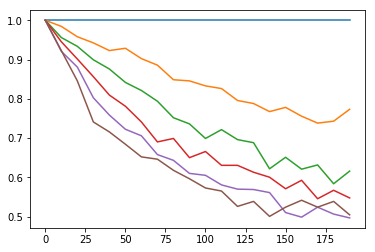

In [62]:
n_qubits = 1
bitIdx = 0

lambdas = [0, 0.001, 0.002, 0.003, 0.004, 0.005]
gateCounts = [x*10 for x in range(20)]

counter = 0
aggregator = {}

for lamb in lambdas:
    y = []
    
    # QuantumError objects
    error = pauli_error([('X', lamb), ('I', 1 - lamb)])

    # Add errors to noise model
    noiseModel = NoiseModel()
    noiseModel.add_quantum_error(error, ['x'], [bitIdx])

    for gateCount in gateCounts:
        counts = CompileAndSimulate(gateCount = gateCount, noiseModel = noiseModel,
                                    n_qubits = n_qubits, bitIdx = bitIdx)
        
        if(counts["0"] == None): 
            p = 0
        else:
            p = counts["0"]/1024
            
        y.append(p)
    
    aggregator[counter] = y
    counter += 1
    plt.plot(gateCounts, y, label="lambda = {0}".format(lamb))
    

## Using the data to fit

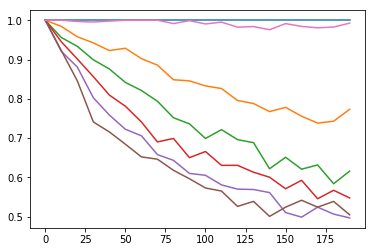

In [68]:
fitted = [] # blank data run

deg = 2 # fit degree

for j in range(20): # 20 bc Harsh's code uses that above
    y = []
    for i in range(len(lambdas)):
        y.append(aggregator[i][j])
        
    intercept = np.polyfit(lambdas, y, deg)
    if intercept[deg] >= 1:
        # constrain the fit to maximize at 1. So if we get
        # above one from polyfit, just set P(0) = 1
        fitted.append(1)
    else:
        fitted.append(intercept[deg])


for run in range(len(lambdas)):
    plt.plot(gateCounts, aggregator[run], label="lambda = {0}".format(lamb))

plt.plot(gateCounts, fitted, label="lambda = {0}".format(lamb))
plt.show()


In [ ]:
def initializer: 
    
    